In [3]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iot-sensors-01:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3715562%2F6438605%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240326%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240326T132242Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2dc6bf7a92739de21d35abb0670f83405cfab5fc634a8a5d5480aeec205aed02676efae1bf19f85930e6afd54f0d52811c3dc2c6d517c9e1656652cfc3d11158a08f84117a9cc48cf8b3038ee38d85c0d9aff0b1298457d42ed72c280100404a30055ac9b24573bb8c3fc6be1d043011954fc8fea155181e542772d0e09a0cce774d7b7d760c53e91b80986813fc66db70b84f7b358cd262a8c3874eebc1b45e7a245c3a437d42b210e0a81028002f20af1b58bed5ac8cd753b50f05072cfedfb7f33ac2ee47392b0e45037c800a400492f3ee3411bd790e95b62be8e3a6c7b181cd24bd8c60f5b010db79610a16e487cd05ba5f2fd3ff71f55f9dc1298f2440'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 10785213 bytes downloaded
Downloaded and uncompressed: iot-sensors-01
Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iot-sensors-01/Sensors_data.csv
/kaggle/input/iot-sensors-01/Heat_index.csv
/kaggle/input/iot-sensors-01/Temperature.csv
/kaggle/input/iot-sensors-01/Humidity.csv


In [5]:
data = pd.read_csv('/kaggle/input/iot-sensors-01/Sensors_data.csv')
data = data.drop(['Unnamed: 0', ], axis=1)

In [6]:
data.describe()

,Heat_index,Humidity,Temperature
count,385872.000000,385872.000000,385872.000000
mean,23.096529,52.172995,23.350587
std,2.657446,11.013673,2.558366
min,15.753450,17.983333,16.400000
25%,21.541057,45.350000,21.733333
50%,23.203913,53.183333,23.366667
75%,25.036140,59.200000,25.200000
max,30.089642,96.300000,29.933333


In [9]:
#Check missing data
data.isnull().sum()/len(data)

_time          0.0
Heat_index     0.0
Humidity       0.0
Temperature    0.0
dtype: float64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385872 entries, 0 to 385871
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   _time        385872 non-null  object 
 1   Heat_index   385872 non-null  float64
 2   Humidity     385872 non-null  float64
 3   Temperature  385872 non-null  float64
dtypes: float64(3), object(1)
memory usage: 11.8+ MB


In [12]:
print(data.columns)


Index(['_time', 'Heat_index', 'Humidity', 'Temperature'], dtype='object')


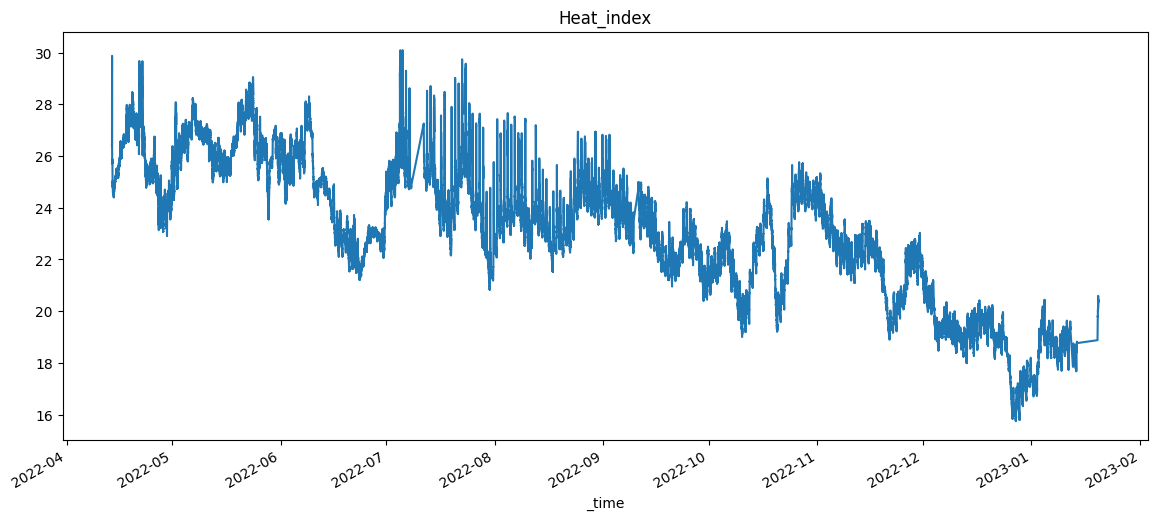

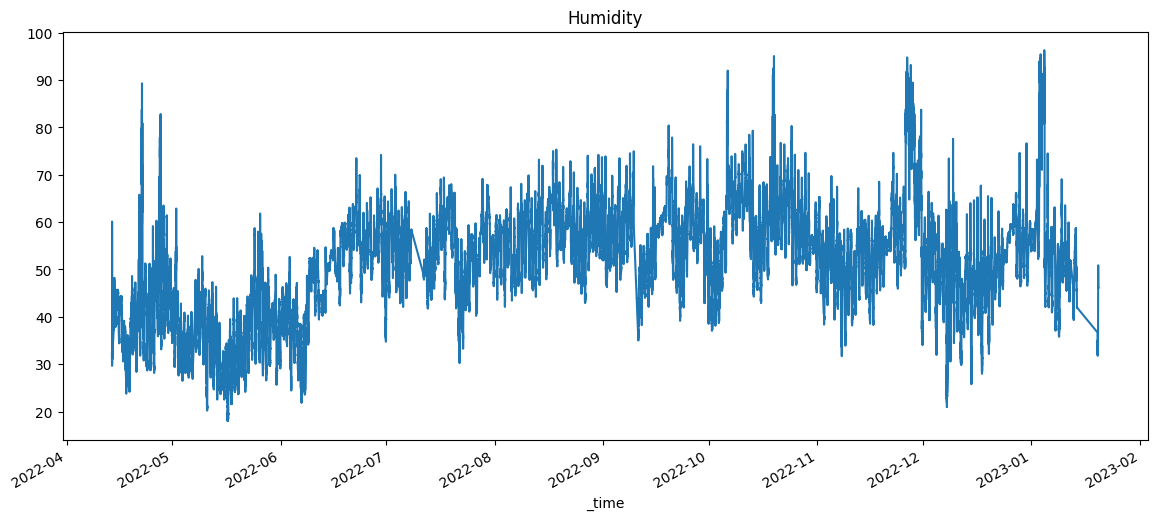

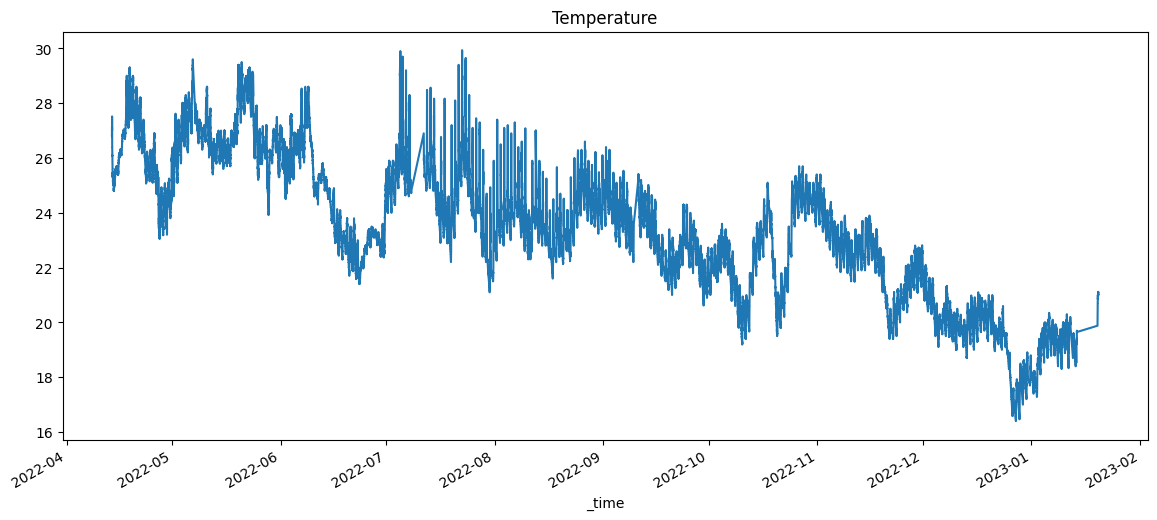

In [13]:

# Convert the '_time' column to datetime
data['_time'] = pd.to_datetime(data['_time'])

data.set_index('_time', inplace=True)

for column in data.columns:
    plt.figure(figsize=(14, 6))
    data[column].plot()
    plt.title(column)
    plt.show()


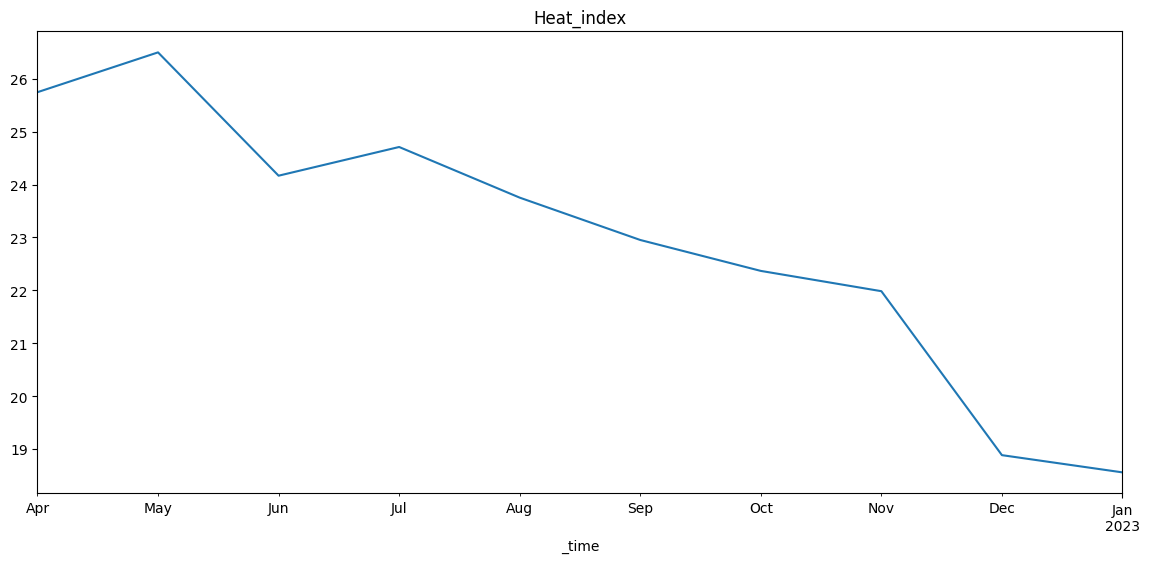

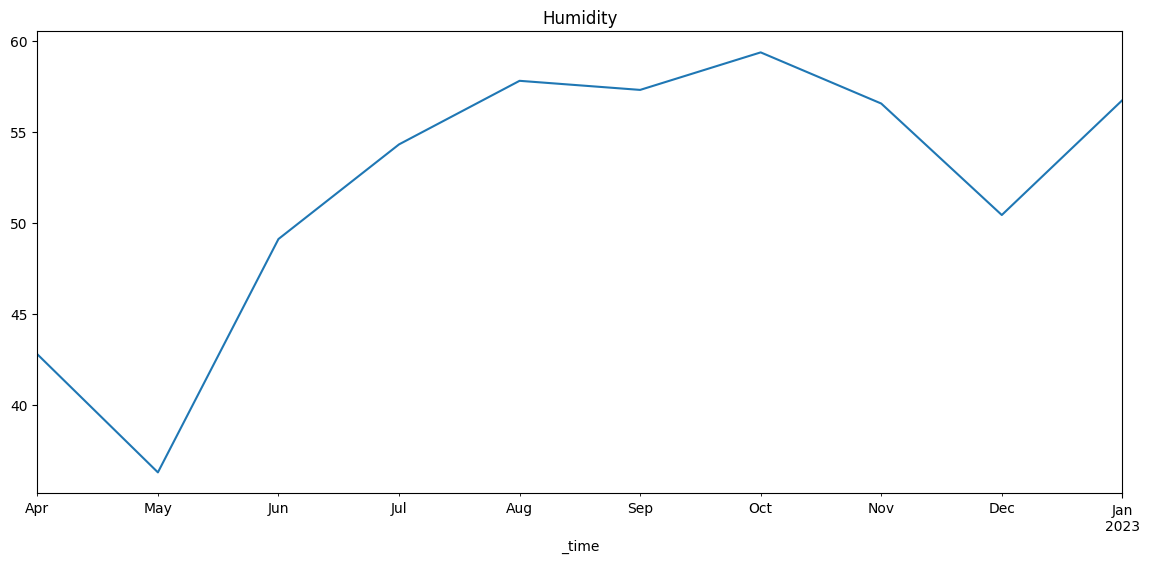

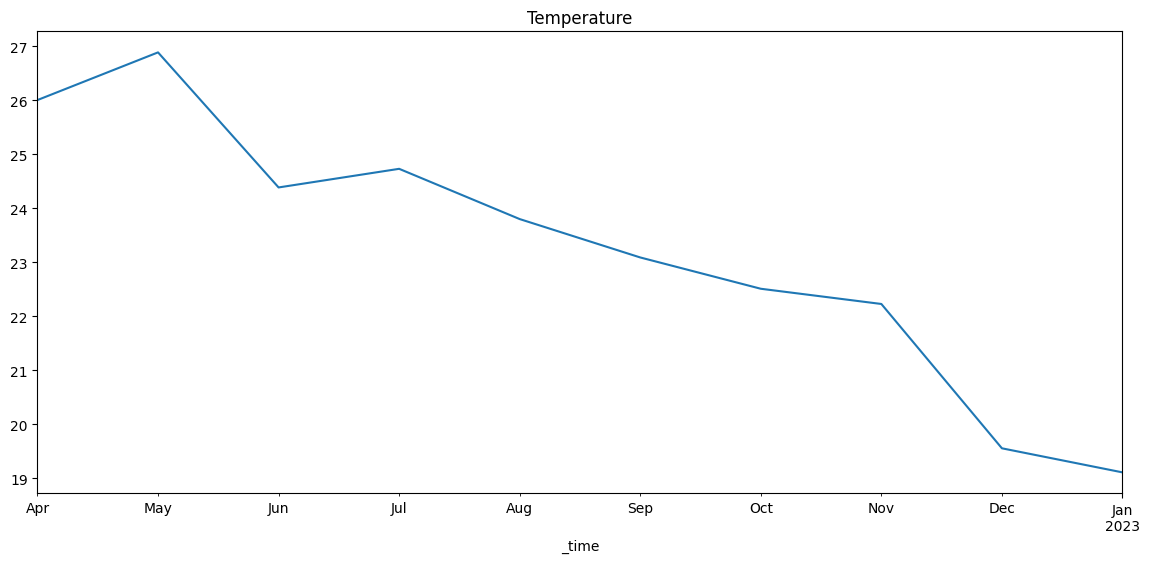

In [14]:
monthly_data = data.resample('M').mean()


for column in monthly_data.columns:
    plt.figure(figsize=(14, 6))
    monthly_data[column].plot()
    plt.title(column)
    plt.show()

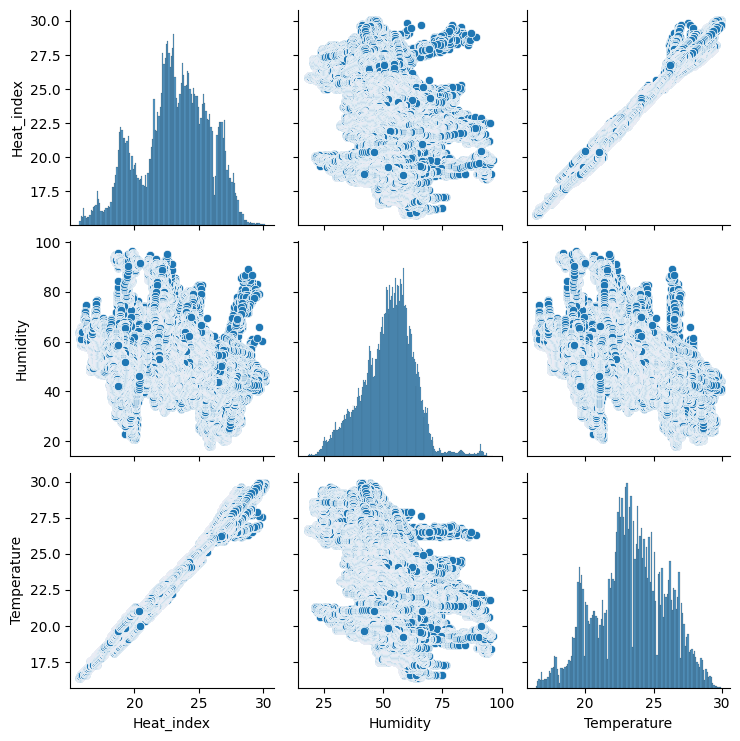

In [15]:
sns.pairplot(data)

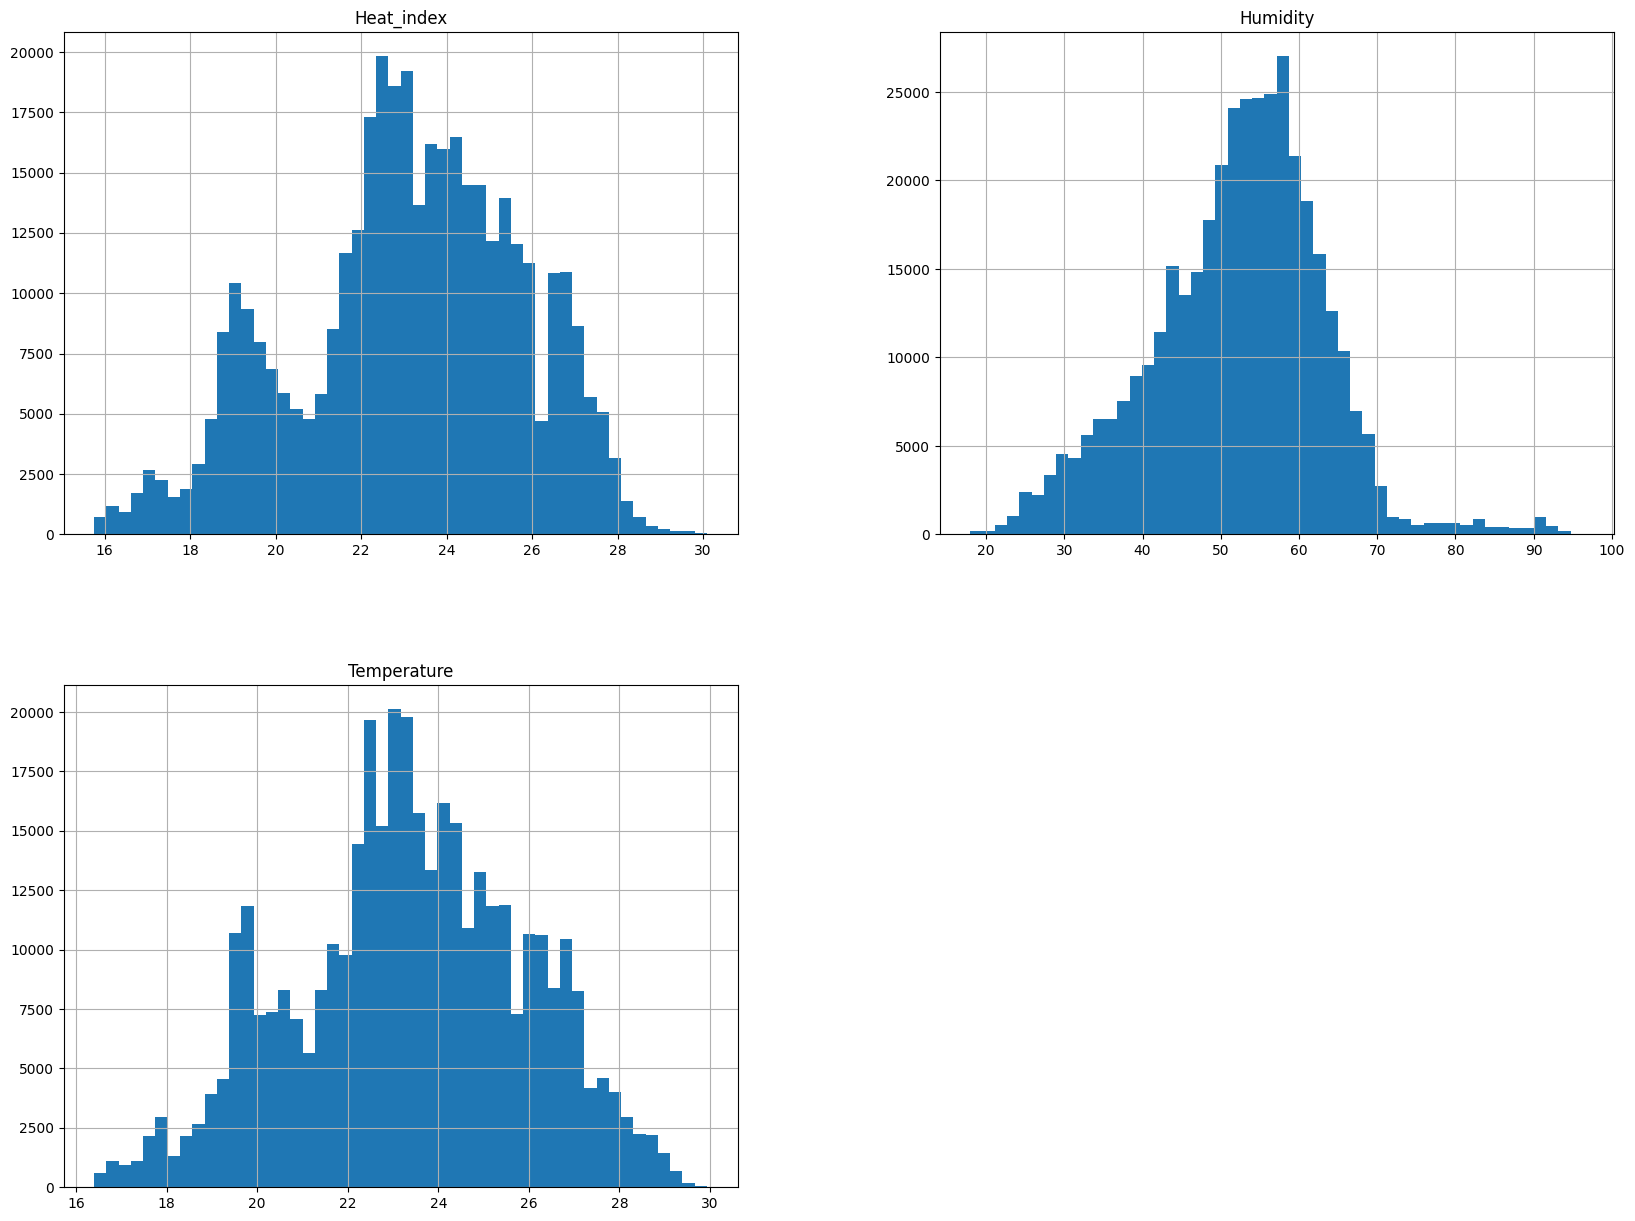

In [16]:
data.hist(bins=50,figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

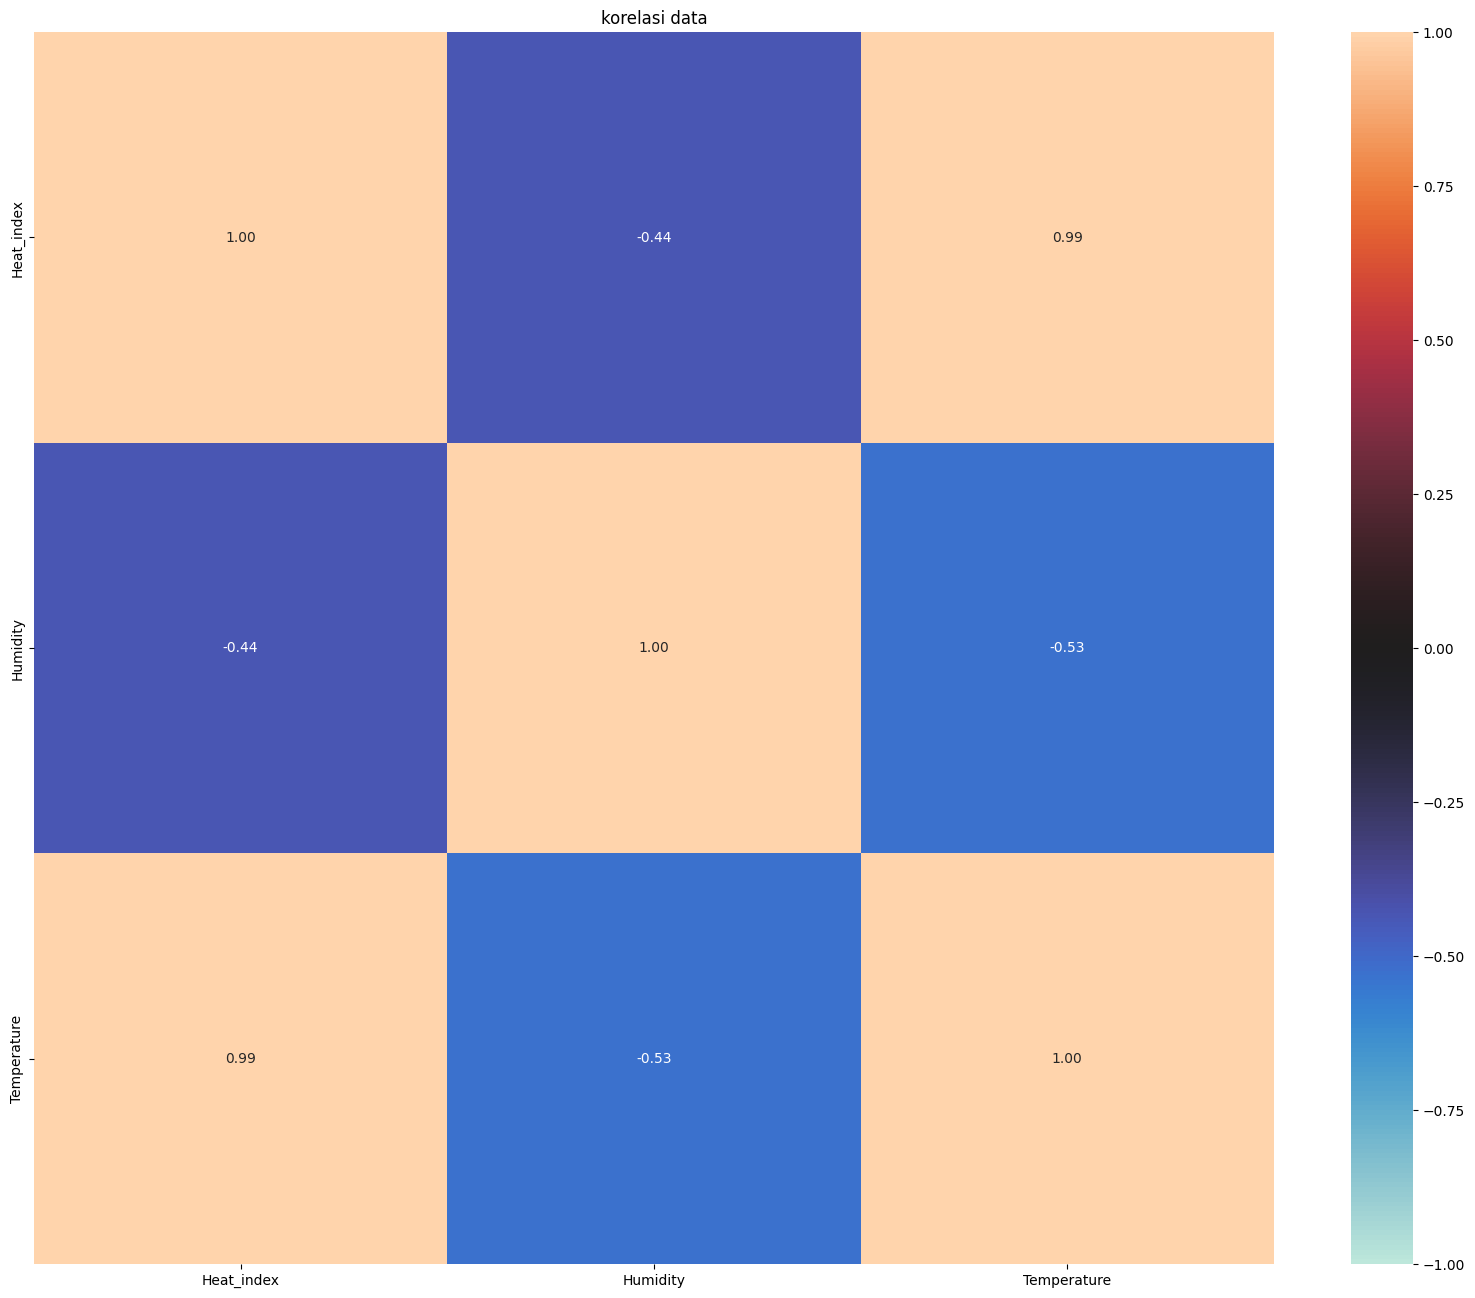

In [17]:
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
fig = plt.subplots(figsize=(20, 16))
sns.heatmap(data[data.columns[0:13].tolist()].corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, center=0)
plt.title('korelasi data', fontsize=12)
plt.show()

In [18]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [19]:
scale = MinMaxScaler()
X = scale.fit_transform(X)
y = scale.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [20]:
#Trying linear regression
lreg = LinearRegression()
lreg.fit(X_train, y_train)
print('Train score', lreg.score(X_train, y_train))
print('Test score', lreg.score(X_test, y_test))

Train score 0.997818210748372
Test score 0.9978284948577876


In [32]:
y_pred = lreg.predict(X_test)

In [22]:
ann = Sequential([Dense(32, activation="relu"),
                 Dense(1, activation='linear')])

ann.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_absolute_error'])


history = ann.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
7718/7718 [==============================] - 34s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0095 - val_loss: 2.9548e-05 - val_mean_absolute_error: 0.0028
Epoch 2/50
7718/7718 [==============================] - 41s 5ms/step - loss: 2.4389e-05 - mean_absolute_error: 0.0030 - val_loss: 1.5594e-05 - val_mean_absolute_error: 0.0028
Epoch 3/50
7718/7718 [==============================] - 32s 4ms/step - loss: 1.2027e-05 - mean_absolute_error: 0.0022 - val_loss: 8.1752e-06 - val_mean_absolute_error: 0.0018
Epoch 4/50
7718/7718 [==============================] - 30s 4ms/step - loss: 7.0979e-06 - mean_absolute_error: 0.0017 - val_loss: 4.0434e-06 - val_mean_absolute_error: 8.4693e-04
Epoch 5/50
7718/7718 [==============================] - 33s 4ms/step - loss: 5.3827e-06 - mean_absolute_error: 0.0014 - val_loss: 5.2023e-06 - val_mean_absolute_error: 0.0018
Epoch 6/50
7718/7718 [==============================] - 31s 4ms/step - loss: 4.6459e-06 - mean_absolute_error: 0.0014 - val_l

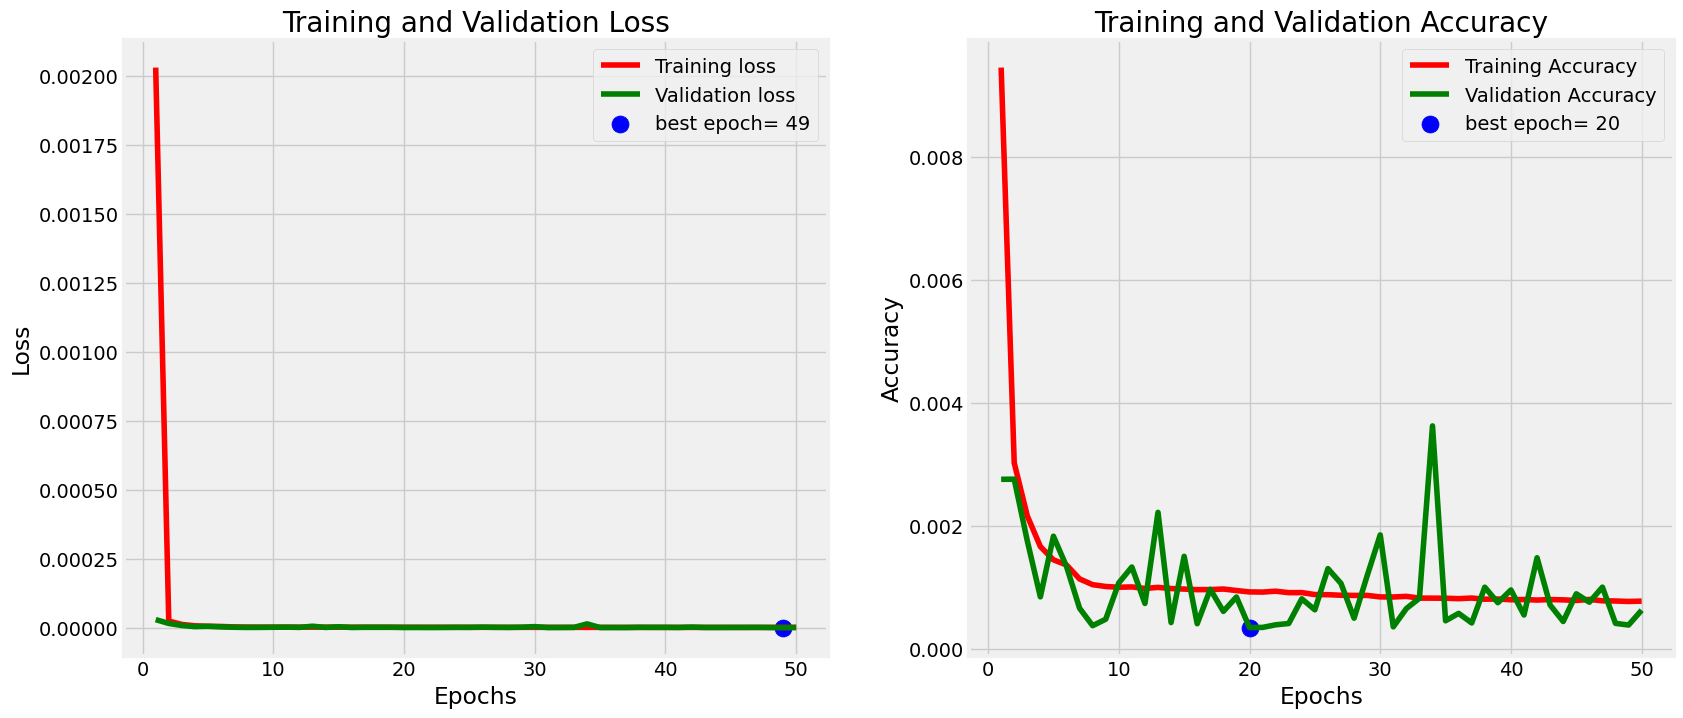

In [23]:
tr_acc = history.history['mean_absolute_error']
tr_loss = history.history['loss']
val_acc = history.history['val_mean_absolute_error']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmin(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [24]:
ann_y_pred = ann.predict(X_test)

2412/2412 [==============================] - 4s 2ms/step


In [25]:
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)

R2 score: 0.9978284948577876


In [26]:
ann.evaluate(X_test, y_test)

2412/2412 [==============================] - 6s 2ms/step - loss: 1.1429e-06 - mean_absolute_error: 6.2942e-04


[1.1428575135141728e-06, 0.0006294237682595849]

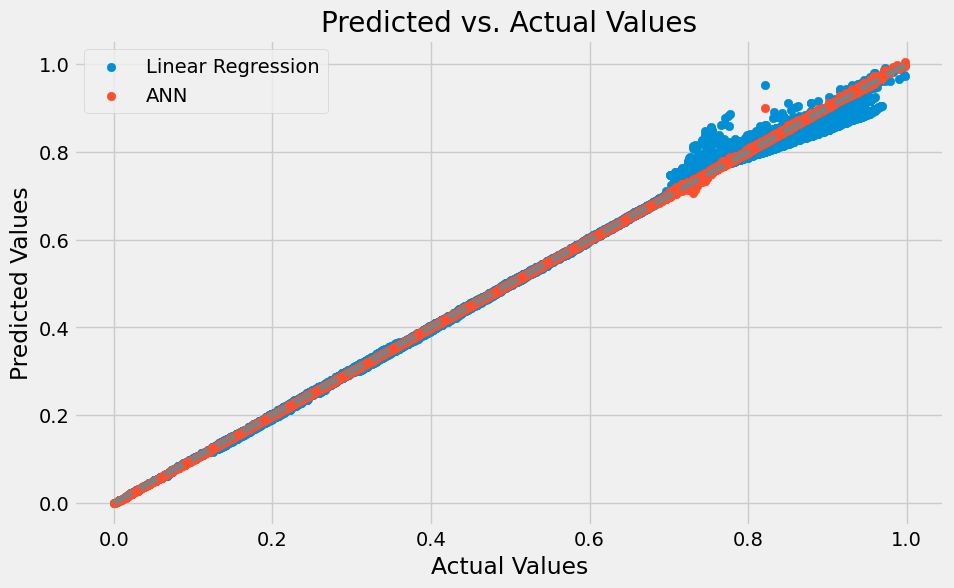

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label='Linear Regression')
plt.scatter(y_test, ann_y_pred, label='ANN')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()

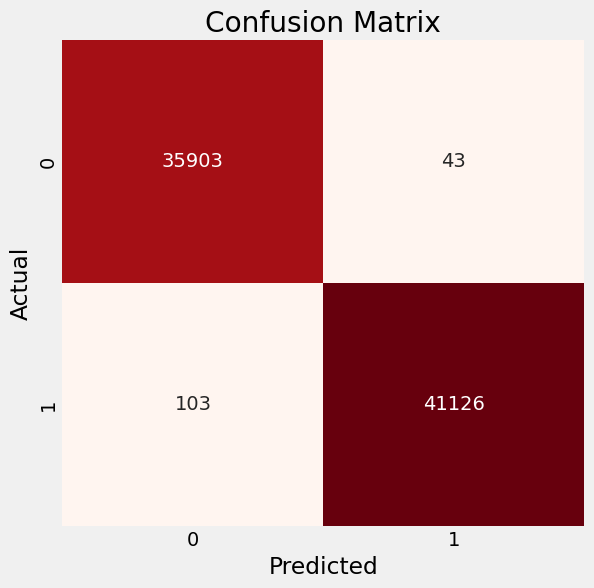

In [31]:

y_pred_binary = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test > 0.5, y_pred_binary)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [29]:
print(classification_report(y_test > 0.5, y_pred_binary))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     35946
        True       1.00      1.00      1.00     41229

    accuracy                           1.00     77175
   macro avg       1.00      1.00      1.00     77175
weighted avg       1.00      1.00      1.00     77175

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     35946
        True       1.00      1.00      1.00     41229

    accuracy                           1.00     77175
   macro avg       1.00      1.00      1.00     77175
weighted avg       1.00      1.00      1.00     77175

